In [1]:
import scanpy as  sc
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import seaborn as sns
import scanpy.external as sce
import harmonypy as hm
print('import successful')

import successful


In [4]:
###global variable###
PCs = 10 
res = 0.2
dataset1='S-MG'
dataset2='S-AG'
dataset = 'S-MAG'
path1=f"../../{dataset1}/1.subset/{dataset1}_cleaned.h5ad"
path2=f"../../{dataset2}/1.subset/{dataset2}_cleaned.h5ad"
vars_use = ['gland']
random.seed(12345)
np.random.seed(12345)
NewCellType = {
    "StemCells": [0,5,6]
}
Featuregenes = ['Esr1','Epcam','Top2a','Acta2','Prlr','Tcf4','Krt23','Lalba','Elf5','Lef1']
doFeatureplot = True
runharmony = True
do_subset_cluster = False
subset_celltype = False
re_find_hvgenes = True
random_state=2024
celltypelist = ['Lum-Immun-like','Lum-Ker-like','Lum-Fibro-like']
sc.settings.figdir = ''
#########################

In [5]:
####function######

In [ ]:
def run_harmony(adata,vars_use=vars_use):
    print('running harmony')
    pca_result = adata.obsm['X_pca']
    ho = hm.run_harmony(pca_result, adata.obs, vars_use,random_state=42)
    adata.obsm['X_pca_harmony'] = ho.Z_corr.T
    print('finished harmony')
    return adata

In [7]:
def export_deg_result(adata):
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    data = []
    for group in groups:
        genes = result['names'][group]
        logfoldchanges = result['logfoldchanges'][group]
        pvals = result['pvals'][group]
        pvals_adj = result['pvals_adj'][group]
        for gene, lfc, pval, pval_adj in zip(genes, logfoldchanges, pvals, pvals_adj):
            data.append([group, gene, lfc, pval, pval_adj])
    df = pd.DataFrame(data, columns=['group', 'gene', 'logfoldchange', 'pval', 'pval_adj'])
    df1 = df[df['pval'] < 0.01]
    return df1

In [8]:
def subsetcelltype(adata,celltypelist):
    adata = adata[~adata.obs['newcelltype'].isin(celltypelist),:].copy()
    return adata

In [ ]:
#######################

In [ ]:
adata1 = sc.read_h5ad(path1)
adata2 = sc.read_h5ad(path2)

In [ ]:
adata1.obs = adata1.obs.drop(columns=["cellid"])
adata2.obs = adata2.obs.drop(columns=["cellid"])

In [ ]:
if subset_celltype:
    adata1 = subsetcelltype(adata1,celltypelist)
    adata2 = subsetcelltype(adata2,celltypelist)
    unique_gland = '-'.join(adata1.obs['gland'].unique().tolist())
    adata1.obs['newcelltype'] = [unique_gland + '-' + str(newtype) for newtype in adata1.obs['newcelltype']]
    unique_gland = '-'.join(adata2.obs['gland'].unique().tolist())
    adata2.obs['newcelltype'] = [unique_gland + '-' + str(newtype) for newtype in adata2.obs['newcelltype']]

In [11]:
adata_combined = adata1.concatenate(adata2,batch_key = 'glandbatch')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15260\3567567213.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata1.concatenate(adata2,batch_key = 'glandbatch')


In [13]:
if re_find_hvgenes:
    adata_combined.X = adata_combined.layers['normalized'].copy()
    # sc.pp.normalize_total(adata_combined)
    # sc.pp.log1p(adata_combined)
    # print('Finish normalized')
    sc.pp.highly_variable_genes(adata_combined, n_top_genes=2000)
    print('Finish Varible genes')
    sc.pp.scale(adata_combined,max_value=10)

Finish normalized
Finish Varible genes


C:\Users\Lenovo\miniconda3\envs\py310\lib\site-packages\scanpy\preprocessing\_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


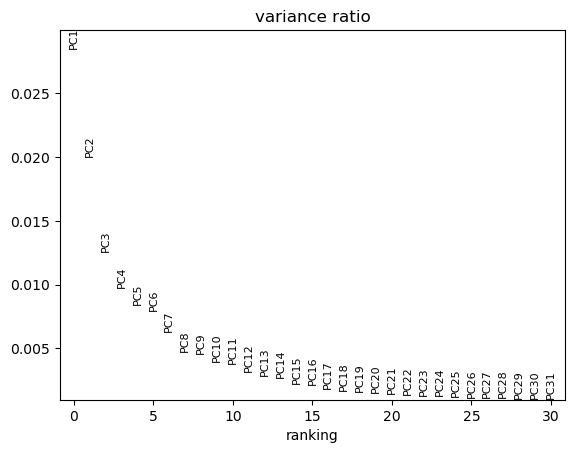

In [14]:
sc.tl.pca(adata_combined,use_highly_variable=True)
sc.pl.pca_variance_ratio(adata_combined,log = False)

In [27]:
if runharmony:
    run_harmony(adata_combined)
    sc.pp.neighbors(adata_combined, use_rep='X_pca_harmony',n_pcs=PCs,random_state=random_state,n_neighbors=15)
else:
    sc.pp.neighbors(adata_combined,n_pcs= PCs,random_state=random_state)
#sc.tl.louvain(ea,resolution = res)
sc.tl.leiden(adata_combined,resolution = res,random_state=random_state)
print('Finish clustering')
sc.tl.umap(adata_combined,random_state=random_state)
print('Finish UMAP')

2024-11-14 16:00:05,217 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


running harmony


2024-11-14 16:00:16,141 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-14 16:00:16,364 - harmonypy - INFO - Iteration 1 of 10
2024-11-14 16:00:46,117 - harmonypy - INFO - Iteration 2 of 10
2024-11-14 16:01:16,555 - harmonypy - INFO - Converged after 2 iterations


finished harmony


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15260\4203893390.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined,resolution = res)


Finish clustering
Finish UMAP


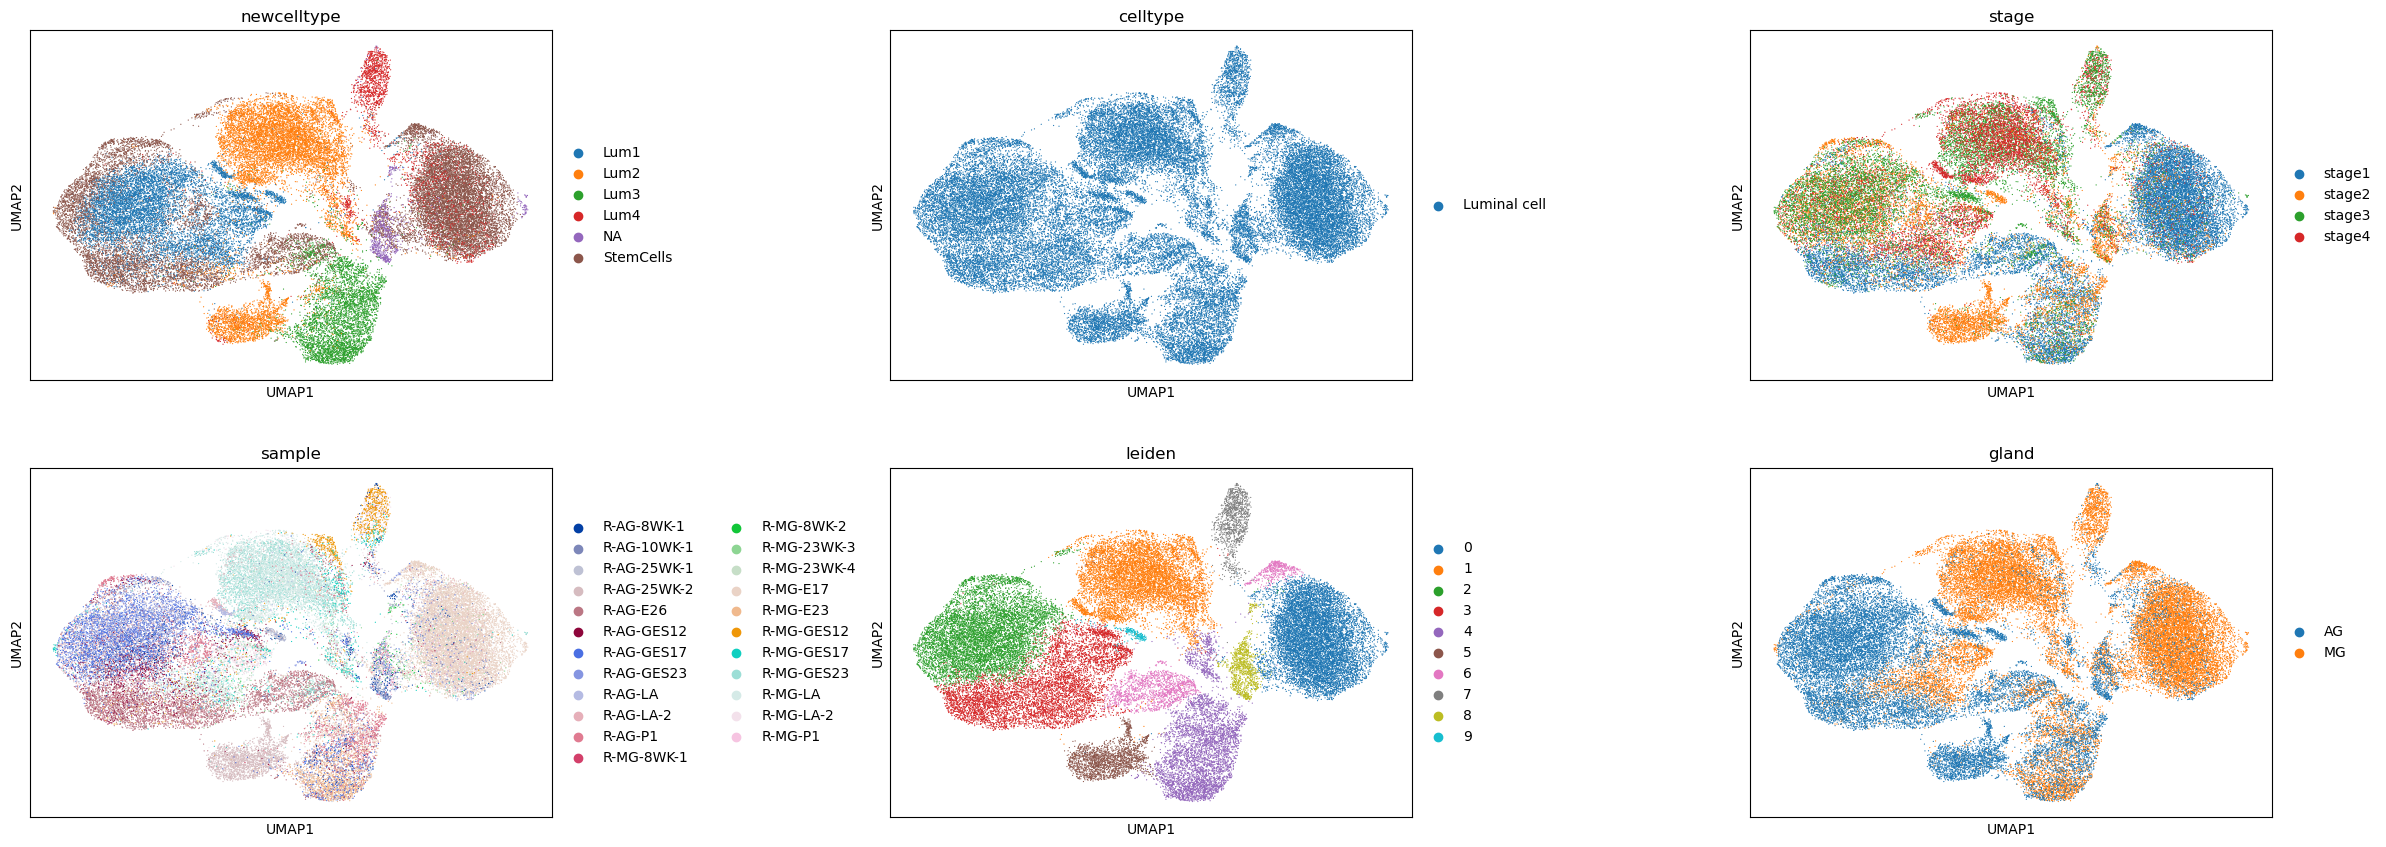

In [29]:
sc.pl.umap(
        adata_combined,
        color=["newcelltype", "celltype", "stage",'sample','leiden','gland'],
        # increase horizontal space between panels
        wspace=0.5,
        size=3,
    ncols=3,
    save=f'{dataset}_merged_celltype.png',
    color_map='viridis'
    )

In [ ]:
adata_combined.write(f'{dataset}_cleaned.h5ad')

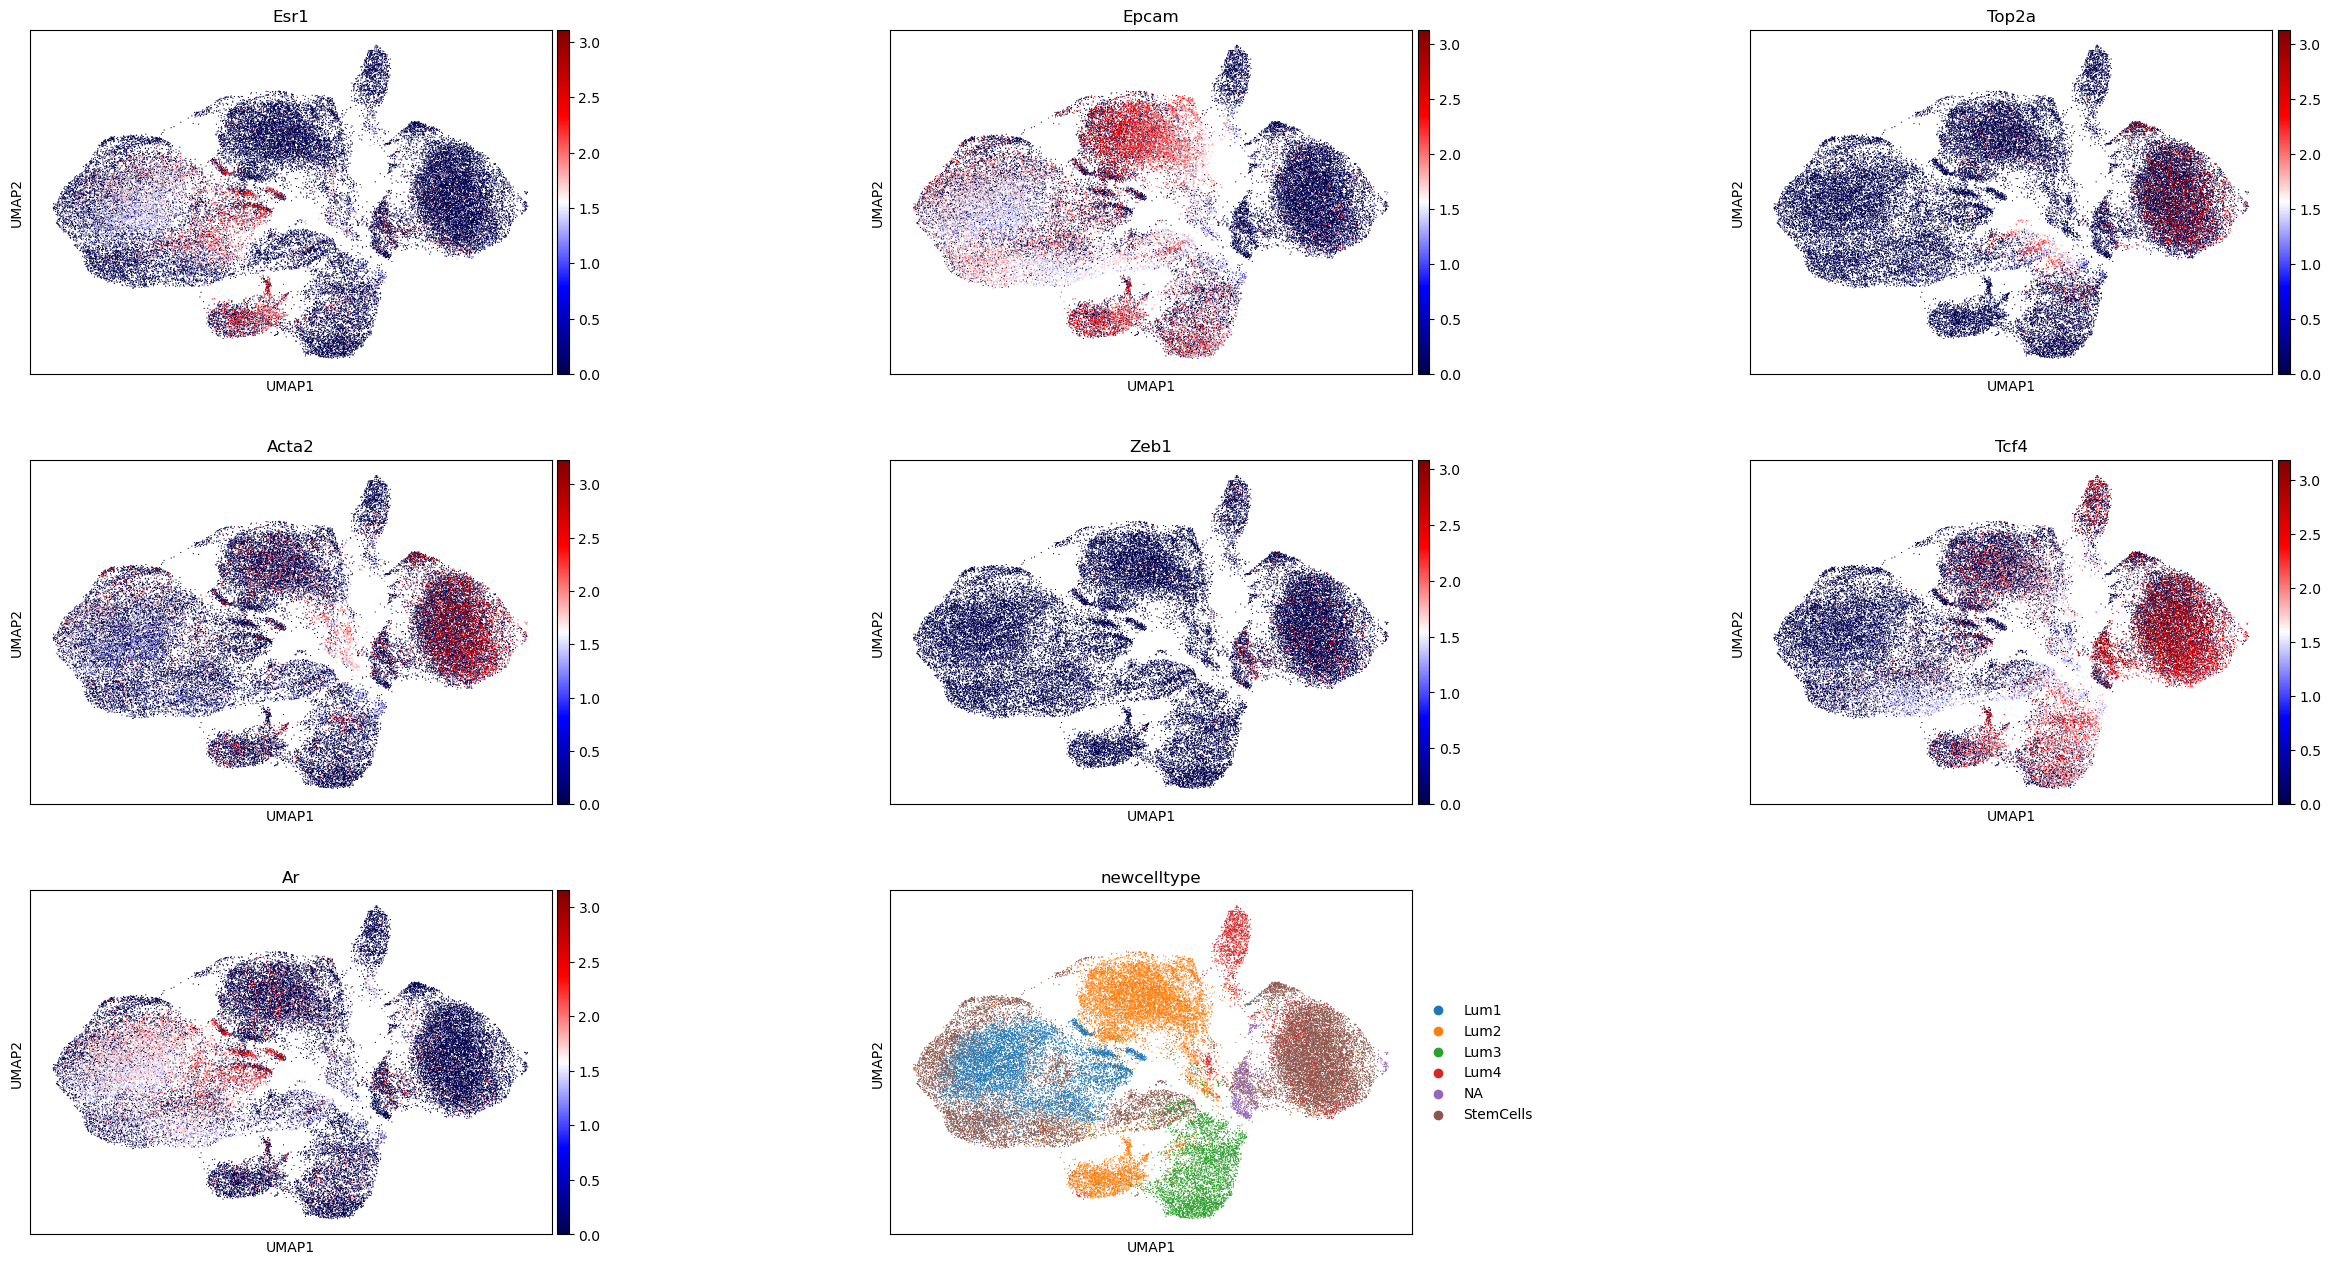

Featureplot Finished


In [30]:
if doFeatureplot:
    sc.pl.umap(
        adata_combined,
        color=[*Featuregenes,'newcelltype','leiden','gland'],
        # increase horizontal space between panels
        wspace=0.5,
        size=3,
    ncols=3,
    save=f'{dataset}_feature.png',
    color_map='seismic',
    )
    print('Featureplot Finished')
else:
    print('666666')

In [ ]:
#### Different gene test###
sc.tl.rank_genes_groups(adata_combined,groupby='newcelltype',method = 'wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_combined,groupby='newcelltype',n_genes=8,save=f'{dataset}_dotplot.png',min_logfoldchange=0.1)

In [ ]:
df1 = export_deg_result(adata=adata_combined)

In [ ]:
df1.to_csv(f'{dataset}_celltype_genes.csv', index=False)

In [ ]:
sc.tl.rank_genes_groups(adata_combined,groupby='leiden',method = 'wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_combined,groupby='leiden',n_genes=8,save=f'{dataset}_dotplot_leiden.png',min_logfoldchange=0.1)

In [ ]:
df1 = export_deg_result(adata=adata_combined)
df1.to_csv(f'{dataset}_leiden_genes.csv', index=False)

In [ ]:
ea = adata_combined

In [ ]:
ea.obs['stage'] = ea.obs['stage'].astype(str)
celltype_counts = ea.obs.groupby(['stage', 'newcelltype']).size().unstack(fill_value=0)
celltype_percentages = celltype_counts.div(celltype_counts.sum(axis=1), axis=0) * 100
celltype_percentages_long = celltype_percentages.reset_index().melt(id_vars='stage', var_name='Celltype', value_name='Percentage')

In [ ]:
default_palette = ea.uns['newcelltype_colors']
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

times = celltype_percentages.index
cell_types = celltype_percentages.columns

colors = sns.color_palette("magma", len(cell_types))
colors = default_palette

bottom = pd.Series([0] * len(times), index=times)


fig3, ax = plt.subplots(figsize=(14, 8))

for cell_type, color in zip(cell_types, colors):
    percentages = celltype_percentages[cell_type]
    ax.bar(times, percentages, bottom=bottom, color=color, label=cell_type)
    bottom += percentages

ax.set_title('Percentage of Each Celltype Over Time', fontsize=16)
ax.set_xlabel('stage', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)

ax.legend(title='Celltype', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
fig3.savefig(f"{dataset}_bar_plot.png")